In [9]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import poppy

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
from adefc_vortex import aefc_1dm as aefc
import adefc_vortex.pwp as pwp
import adefc_vortex.scoob_model as scoobm
import adefc_vortex.scoob_interface as scoobi

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient
client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

wavelength_c = 633e-9
npix = 1000


In [10]:
scoobi.home_block(client0)

In [11]:
scoobi.move_block_out(client0)

In [12]:
reload(scoobi)
xc, yc = (4600, 3400)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [13]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp05')
I.npsf = 150

# Do the normalization

In [18]:
scoobi.move_psf(50, 0, client0)

In [20]:
scoobi.move_psf(0, -50, client0)

In [21]:
reload(scoobi)
I.set_zwo_exp_time(0.000120, client0)

Set the ZWO exposure time to 1.20e-04s


In [22]:
reload(scoobi)
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [23]:
reload(scoobi)
I.set_fib_atten(30, client)

Set the fiber attenuation to 30.0


INFO:utils:Got semaphore index 1.


49674.73


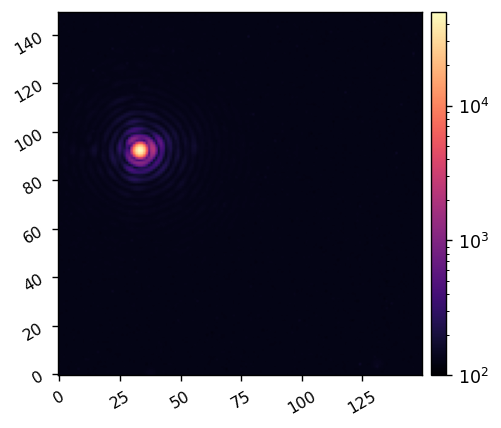

In [24]:
I.NSCICAM = 400
ref_psf = I.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)

In [25]:
I.ref_psf_params = {
    'ref_psf':copy.copy(ref_psf),
    'Imax': copy.copy(xp.max(ref_psf)),
    'texp': copy.copy(I.texp), 
    'atten': copy.copy(I.atten),
    'gain': copy.copy(I.gain),
}
utils.save_pickle(f'data/{today}_ref_psf_params_aefc.pkl', I.ref_psf_params)

# I.ref_psf_params = utils.load_pickle(f'data/{today}_ref_psf_params.pkl')

print(I.ref_psf_params)

Saved data to:  data/20250121_ref_psf_params_aefc.pkl
{'ref_psf': array([[128.35, 130.86, 127.77, ..., 129.5 , 127.27, 129.67],
       [126.53, 126.86, 128.27, ..., 128.42, 128.28, 127.34],
       [127.2 , 128.11, 127.43, ..., 129.23, 128.61, 127.27],
       ...,
       [128.82, 127.87, 129.22, ..., 127.27, 127.7 , 128.85],
       [128.12, 126.95, 127.94, ..., 126.64, 127.7 , 127.99],
       [125.92, 128.58, 128.21, ..., 128.12, 128.54, 128.07]]), 'Imax': array(49674.73), 'texp': 0.00012, 'atten': 30, 'gain': 120}


In [59]:
scoobi.move_psf(1, 0, client0)


In [64]:
scoobi.move_psf(0, 1, client0)

In [66]:
I.set_fib_atten(22, client)

Set the fiber attenuation to 22.0


In [65]:
I.set_zwo_exp_time(0.1, client0)

Set the ZWO exposure time to 1.00e-01s


In [67]:
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [41]:
reload(scoobi)
scoobi.move_block_in(client0)

Saved data to:  data/20250121_camsci_dark_frame_0.100000.pkl


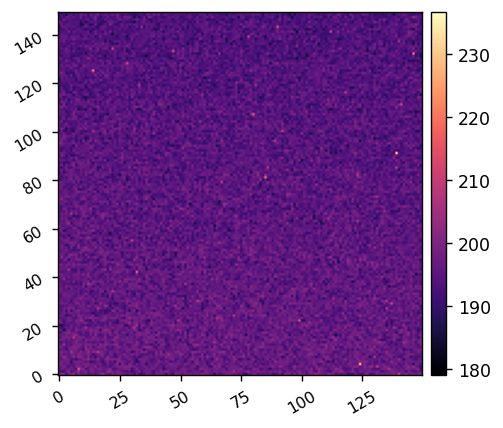

In [42]:
I.NSCICAM = 100
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
utils.save_pickle(f'data/{today}_camsci_dark_frame_0.100000.pkl', dark_frame)
imshow1(dark_frame)

# dark_frame = utils.load_pickle(f'data/20250116_camsci_dark_frame_0.100000.pkl')
# imshow1(dark_frame)

I.df = copy.copy(dark_frame)

In [43]:
reload(scoobi)
scoobi.move_block_out(client0)

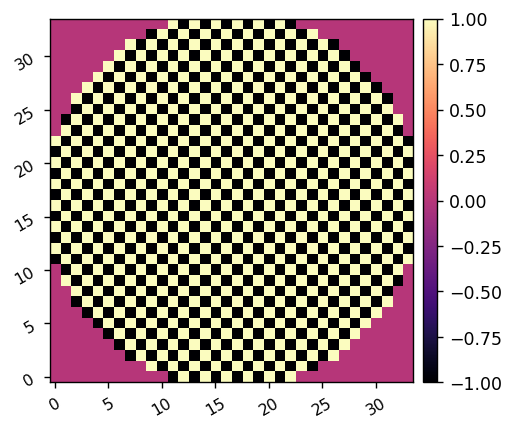

In [68]:
reload(scoobi.utils)
waffle_command = utils.make_fourier_command(x_cpa=17, y_cpa=17) * xp.array(I.dm_mask)
imshow1(waffle_command)

In [89]:
I.set_fib_atten(22, client)

Set the fiber attenuation to 22.0


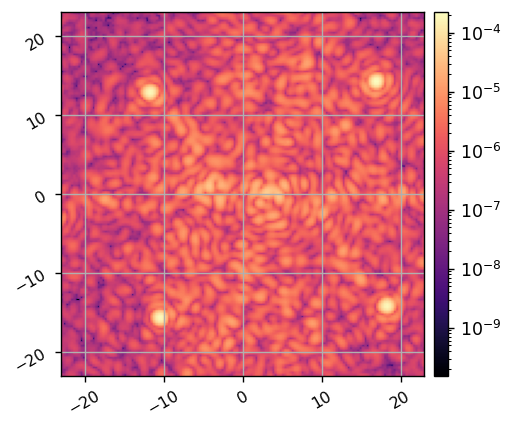

In [69]:
I.set_dm(10e-9 * waffle_command)
I.x_shift = 0
I.y_shift = 0

# original_texp = I.texp
# I.set_zwo_exp_time(0.005, client0)

I.NSCICAM = 10
I.subtract_dark = True
I.return_ni = True
waffle_im = I.snap()
imshow1(
    waffle_im, 
    lognorm=True, 
    # vmin=1e-7, 
    pxscl=I.psf_pixelscale_lamDc, 
    grid=True,
)

# I.set_zwo_exp_time(original_texp, client0)


Centroids:
 [[ 40.31126296  23.54369658]
 [ 36.26832996 116.47856351]
 [129.49449351 120.86418582]
 [133.75693133  28.44250672]
 [ 40.31126296  23.54369658]]


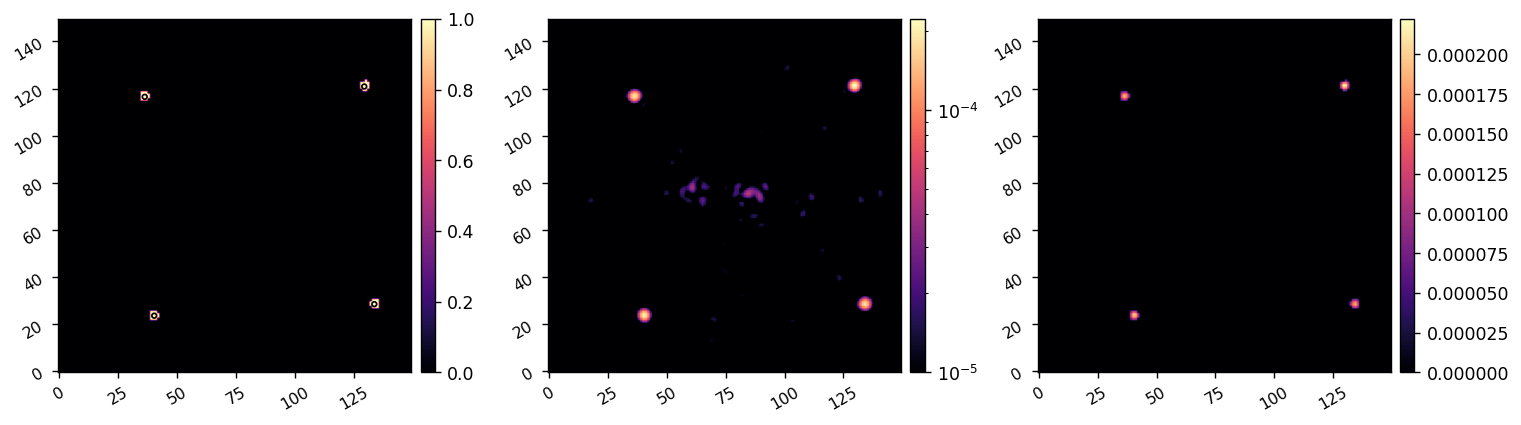

Angle:  87.29353883423416
Measured center in X:  85.08124055570644
Measured center in Y:  72.3985776580171
Required shift in X:  -10.0
Required shift in Y:  3.0


In [70]:
reload(utils)

xshift, yshift, angle = utils.measure_center_and_angle(
    waffle_im, 
    I.psf_pixelscale_lamDc, 
    im_thresh=7e-5, 
    r_thresh=16,
)

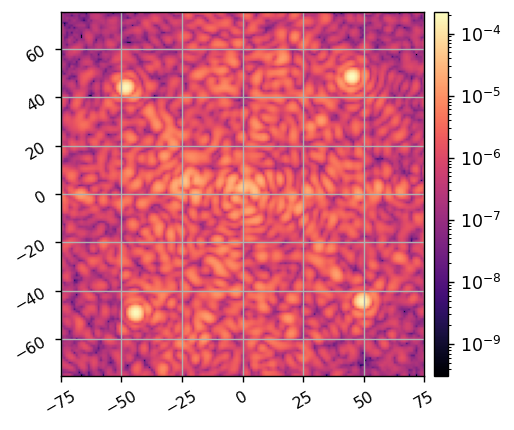

In [71]:
I.NSCICAM = 10
I.npsf = 150
I.x_shift = xshift
I.y_shift = yshift-1

I.subtract_dark = True
I.return_ni = True

waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=1, grid=True)

In [72]:
I.set_fib_atten(20, client)

Set the fiber attenuation to 20.0


In [73]:
I.zero_dm()

In [96]:
print(I.texp, I.atten, I.gain)
print(I.ref_psf_params)

0.1 15 120
{'ref_psf': array([[127.34, 129.63, 128.09, ..., 129.45, 127.33, 128.7 ],
       [126.04, 126.76, 127.71, ..., 127.72, 128.47, 127.31],
       [127.25, 127.71, 127.97, ..., 128.11, 127.69, 126.18],
       ...,
       [128.6 , 128.04, 128.19, ..., 127.27, 127.27, 128.  ],
       [128.77, 126.98, 127.58, ..., 127.63, 127.22, 127.52],
       [128.98, 128.12, 128.34, ..., 127.92, 127.49, 127.59]]), 'Imax': array(41188.75), 'texp': 0.00012, 'atten': 32, 'gain': 120}


2.181872828295629e-06


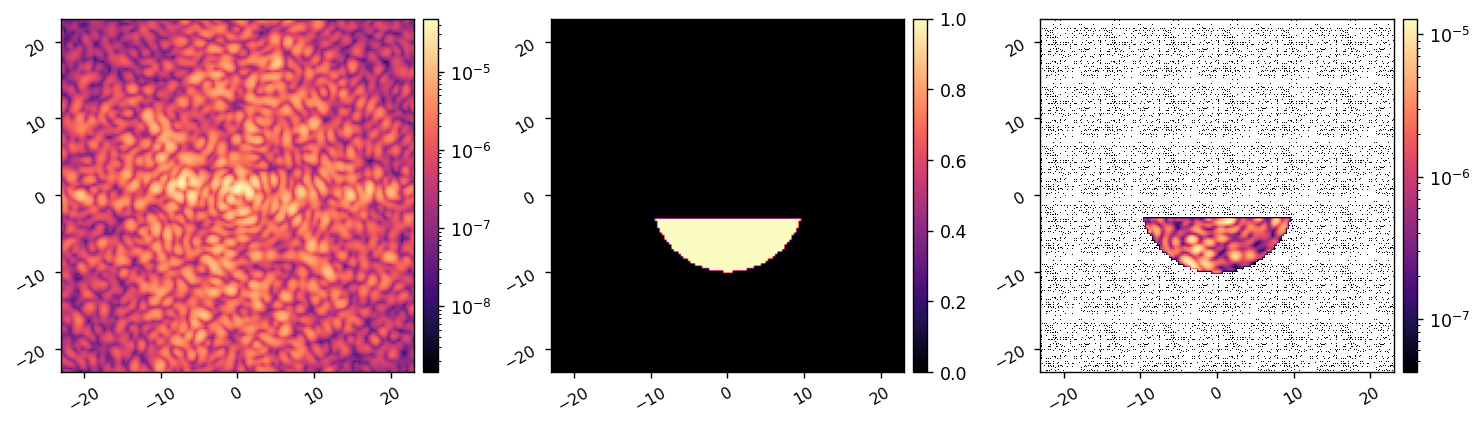

In [74]:
iwa = 3
owa = 10
rotation = 90
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, iwa, owa, edge=iwa, rotation=rotation)

I.zero_dm()
I.NSCICAM = 50
I.subtract_dark = True
I.return_ni = True

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamDc)

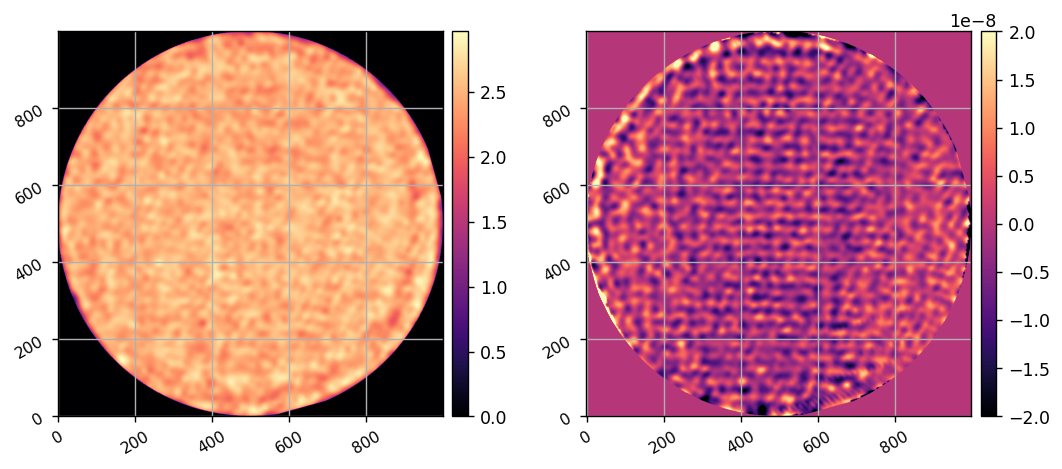

In [75]:
# pr_fit = utils.load_pickle(f'data/20250114_fdpr2_ref_processed.pkl')
pr_fit = utils.load_pickle(f'data/20250121_fdpr2_prefpm_ref_processed.pkl')

wfe_amp = pr_fit['amp']
wfe_opd = pr_fit['opd']

opd_vmax = 20e-9
imshow2(
    wfe_amp, wfe_opd,
    vmax2=opd_vmax, vmin2=-opd_vmax,
    grid=True,
)

In [90]:
16/34 * 2 * 10.2

9.6

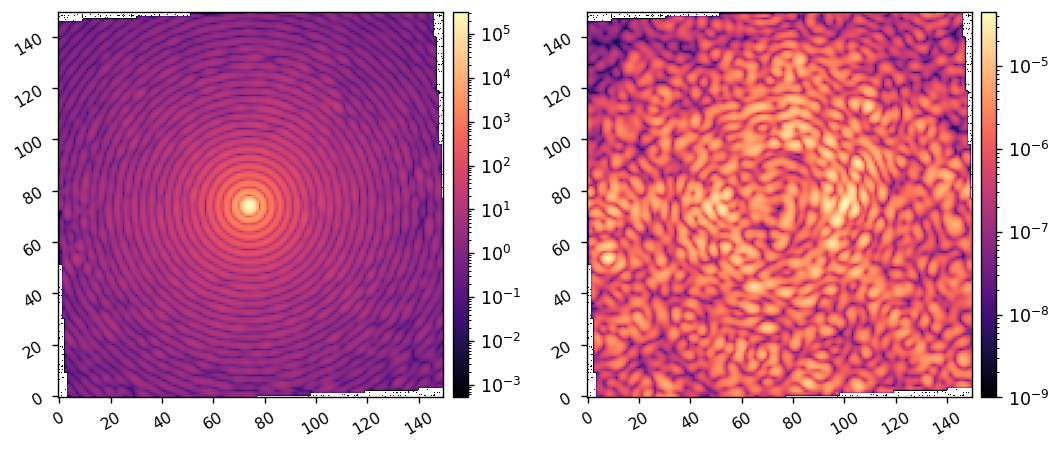

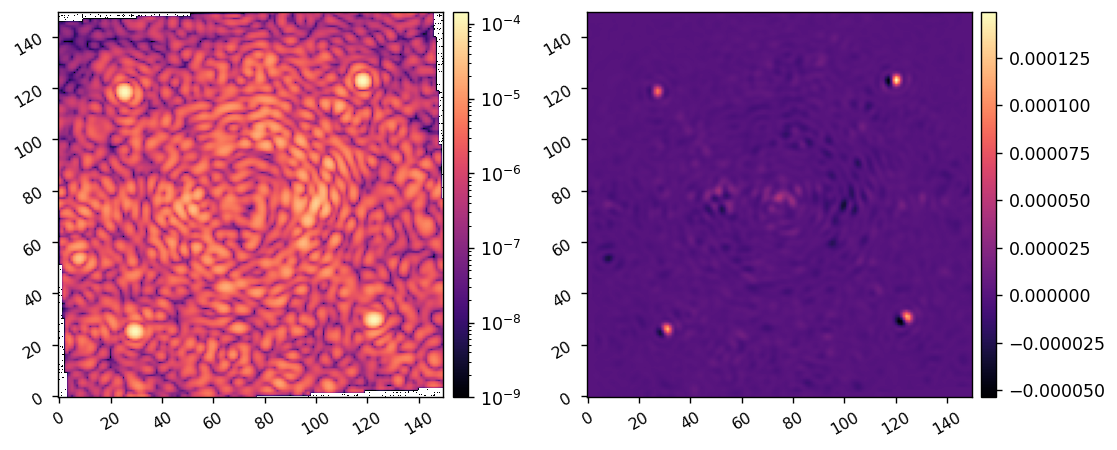

In [76]:
reload(scoobm)
M = scoobm.MODEL(
    # dm_beam_diam=9.4*u.mm, 
    # lyot_pupil_diam=9.4*u.mm,
    # dm_shift=np.array([0.075,0])*u.mm,
    # lyot_shift=np.array([0.0,0.15])*u.mm,
    # dm_beam_diam=9.1*u.mm, 
    # lyot_pupil_diam=9.1*u.mm,
    # dm_shift=np.array([0.1,0.0])*u.mm,
    lyot_shift=np.array([0.075,0.15])*u.mm,
)
M.AMP = wfe_amp
M.OPD = wfe_opd
# M.npsf = 256

M.reverse_lyot = 1
M.flip_lyot = 1
M.det_rotation = 177.3
# M.det_rotation = -2.75

M.setattr('use_vortex', False)
m_ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(m_ref_psf))

M.setattr('use_vortex', True)
m_coro_im = M.snap()

imshow2(
    m_ref_psf, m_coro_im, 
    lognorm=1,
    vmin2=1e-9,
)

M.set_dm(5e-9 * waffle_command)
m_waffle_im = M.snap()
M.zero_dm()

imshow2(
    m_waffle_im, waffle_im-m_waffle_im, 
    lognorm1=True, 
    vmin1=1e-9,
)
# fpwf = M.forward(np.zeros(M.Nacts), use_vortex=True, plot=True)


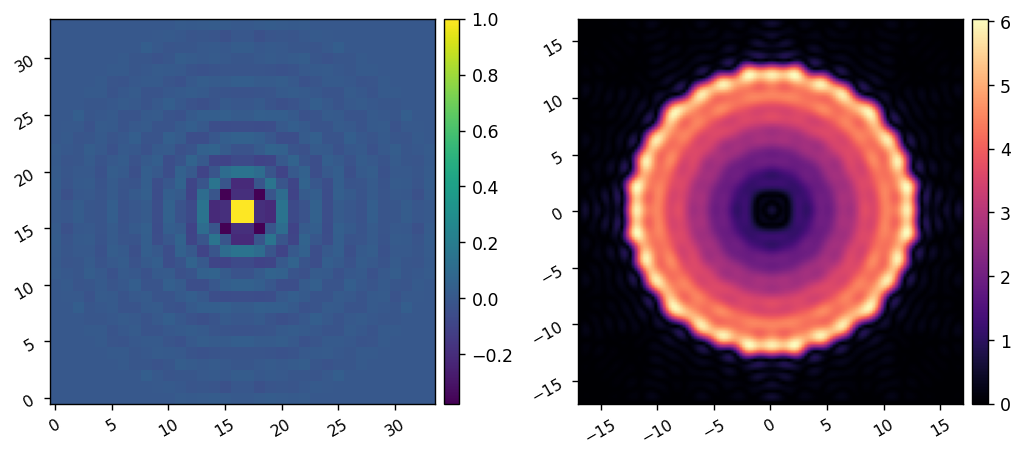

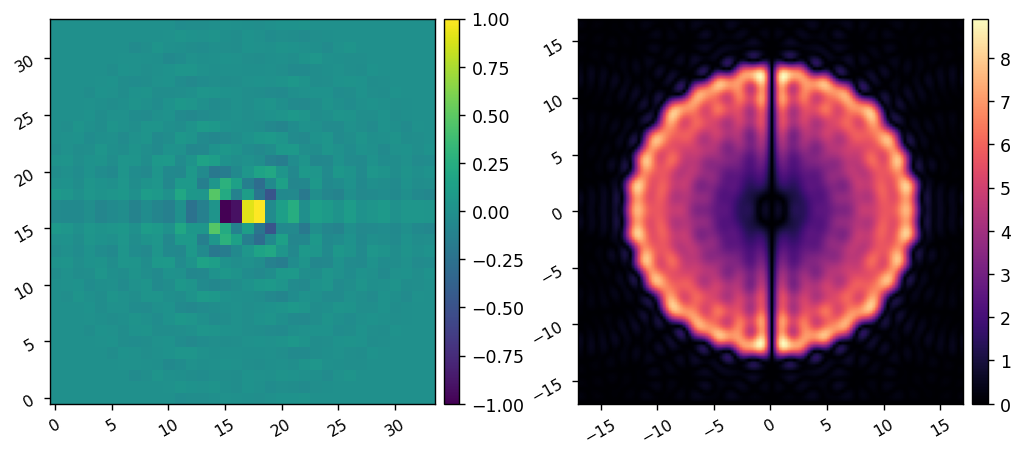

In [77]:
reload(utils)
fourier_probes = utils.create_fourier_probes(
    xp.array(I.dm_mask), 
    I.npsf, 
    I.psf_pixelscale_lamDc, 
    iwa-0.5, owa+2, 
    # edge=iwa-0.5,
    fourier_sampling=0.75, 
    # rotation=90,
    nprobes=2,
    plot=True,
    use_weighting=True
)
fourier_probes[0] = xp.rot90(fourier_probes[0])
fourier_probes[1] = xp.rot90(fourier_probes[1])

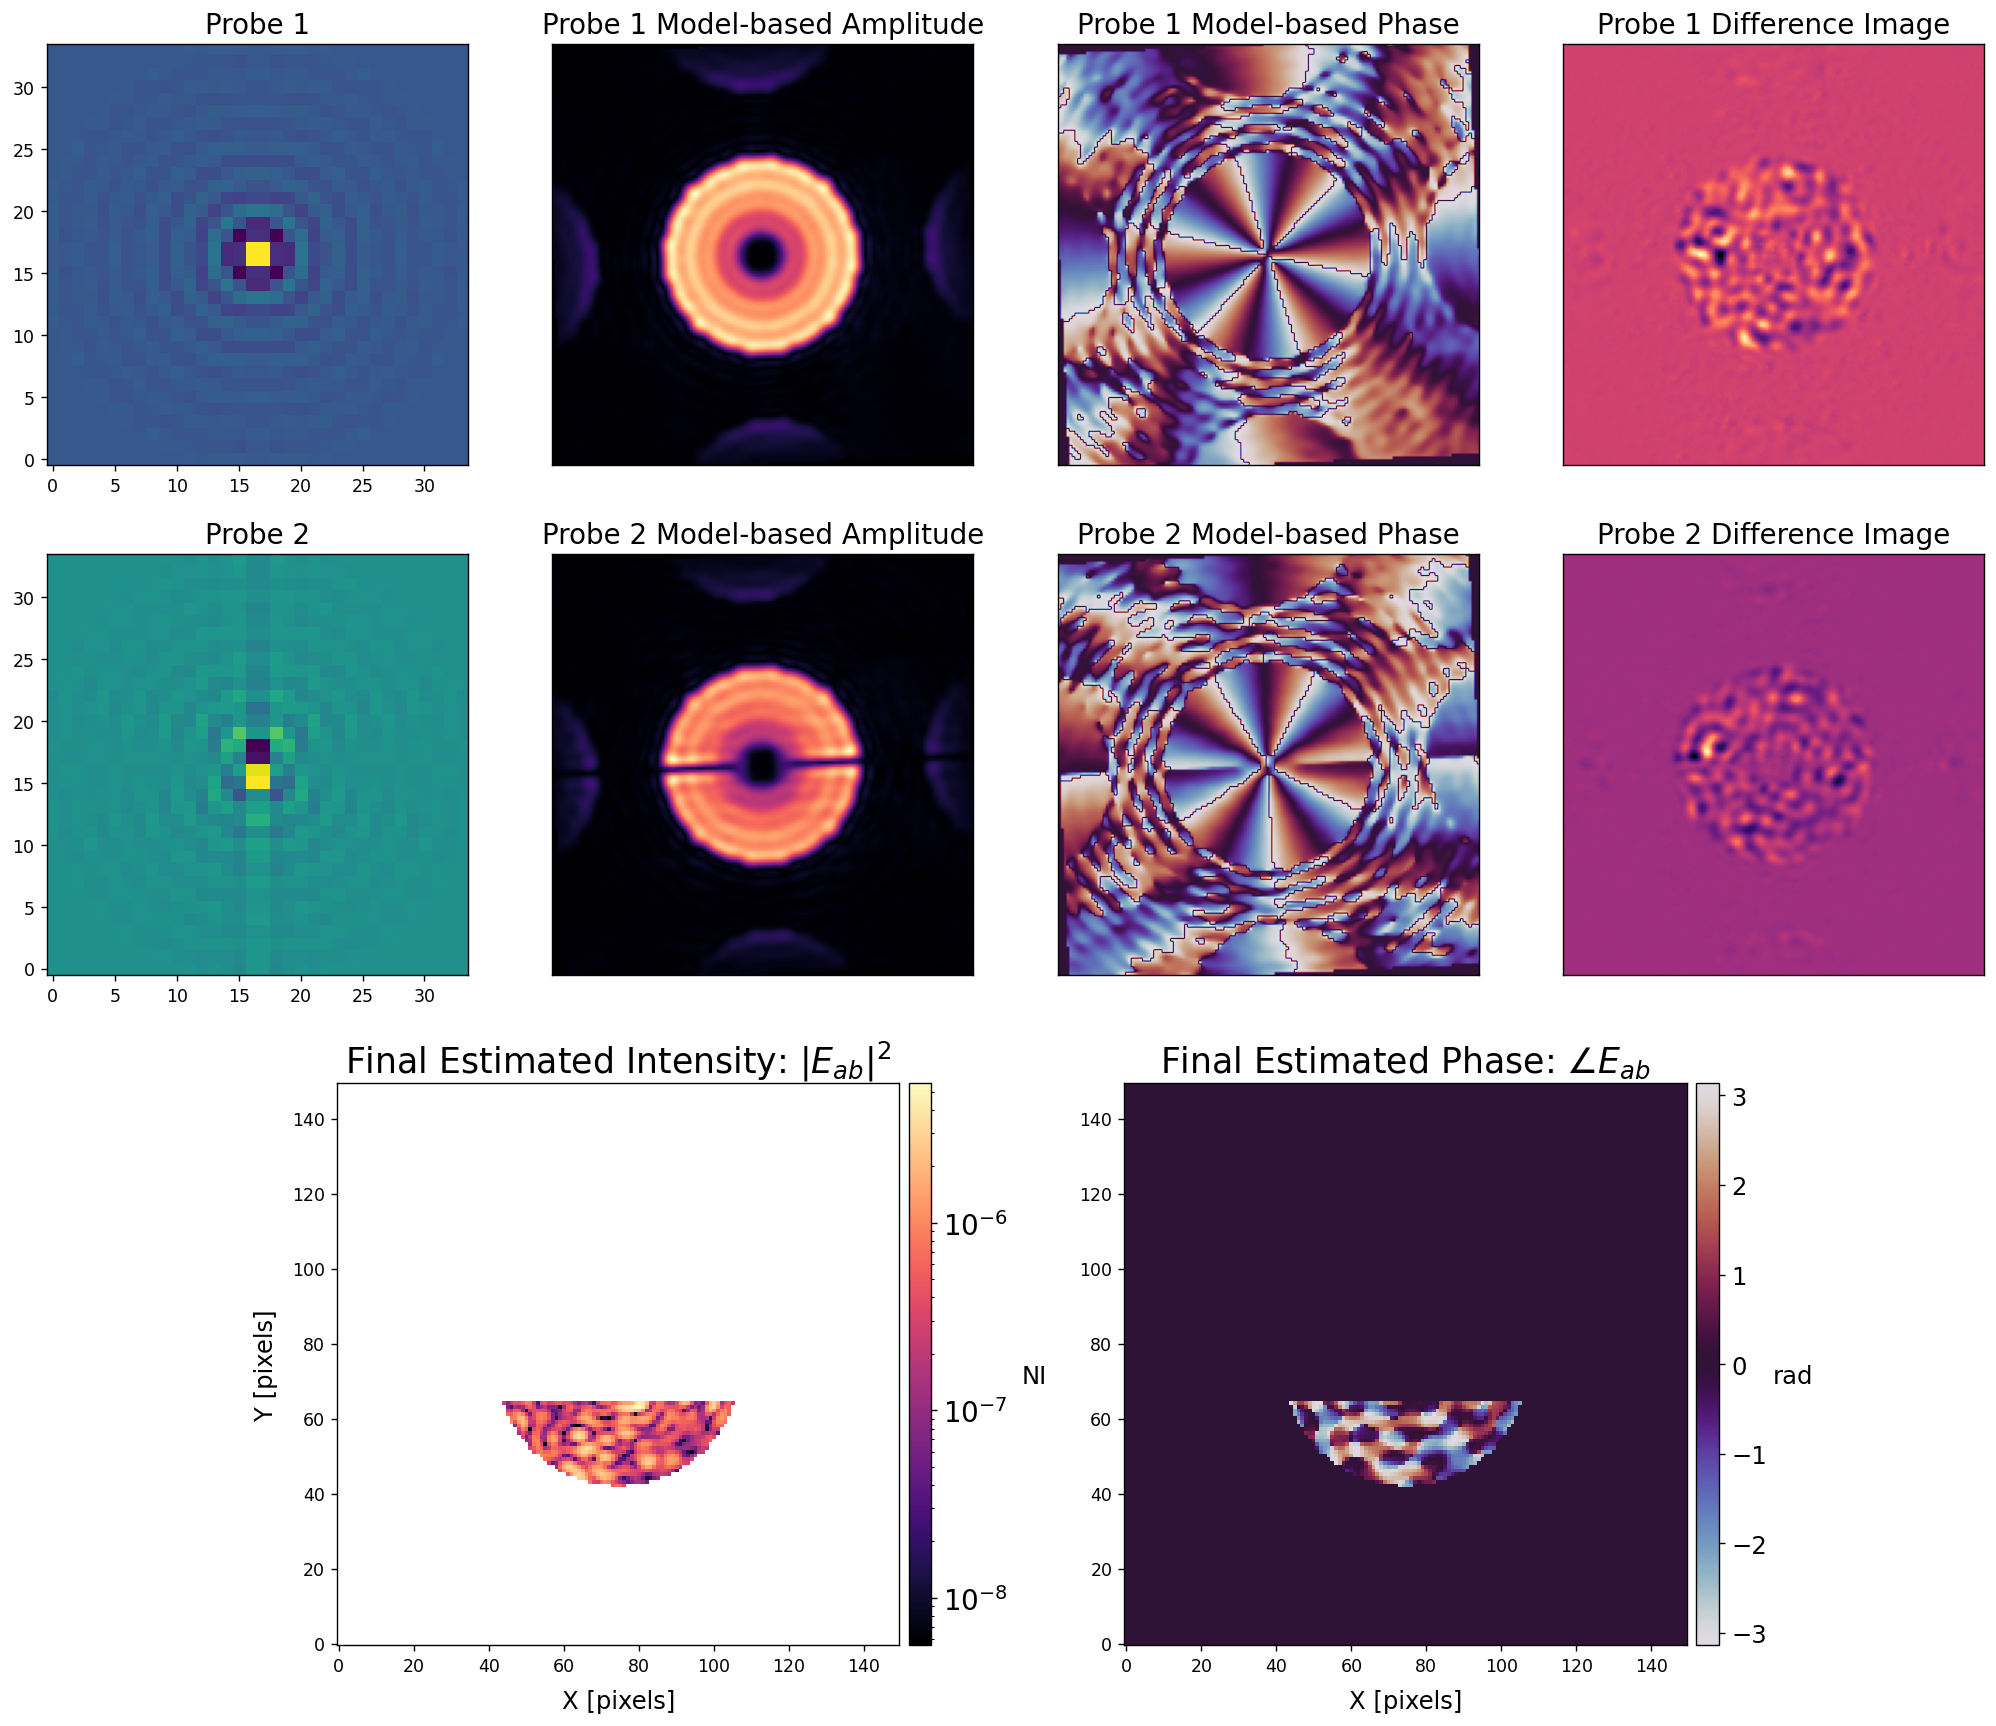

In [78]:
reload(pwp)

acts = xp.zeros(M.Nacts)

I.set_dm(scoobm.acts_to_command(acts, M.dm_mask))
E_pwp = pwp.run(
    I, 
    M, 
    control_mask, 
    fourier_probes, 
    2.5e-9, 
    I.wavelength_c, 
    reg_cond=1e-2, 
    # gain=2.5,
    Ndms=1,
    plot=True,
)
I_pwp = xp.abs(E_pwp)**2
P_pwp = xp.angle(E_pwp)

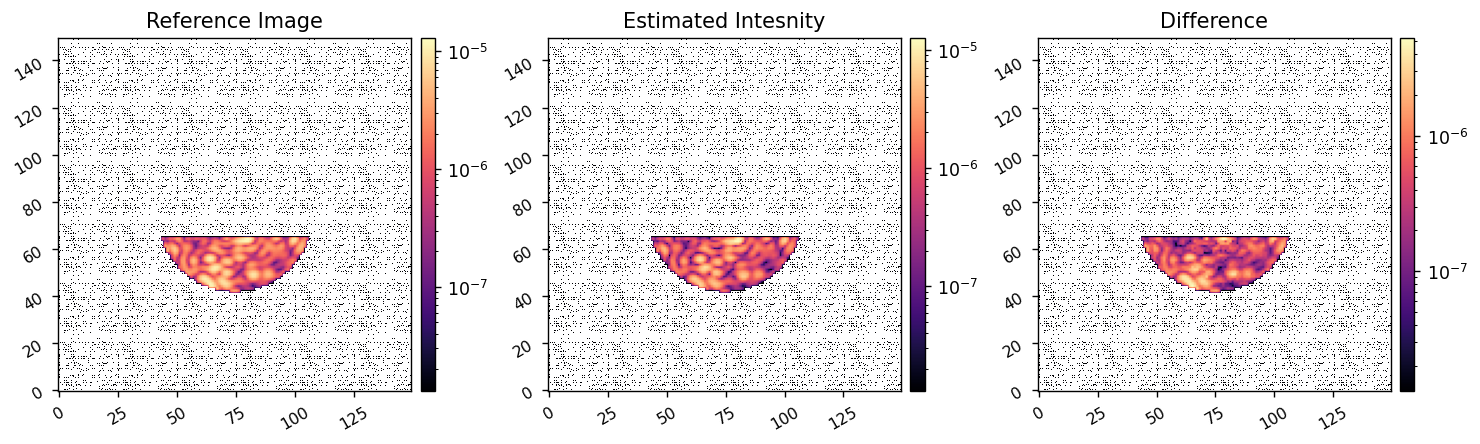

In [82]:
sf = 2.25
I_diff = ref_coro_im*control_mask - sf*I_pwp
vmin = xp.max(ref_coro_im*control_mask)/1e3
imshow3(
    ref_coro_im*control_mask, sf*I_pwp, xp.abs(I_diff), 
    'Reference Image', 'Estimated Intesnity', 'Difference',
    lognorm1=True, lognorm2=True, 
    vmin1=vmin, vmin2=vmin, 
    lognorm3=True, vmin3=vmin,
)

In [277]:
scoobi.move_psf(-1, 0, client0)

In [281]:
scoobi.move_psf(0, -1, client0)

2.1666505133769236e-06


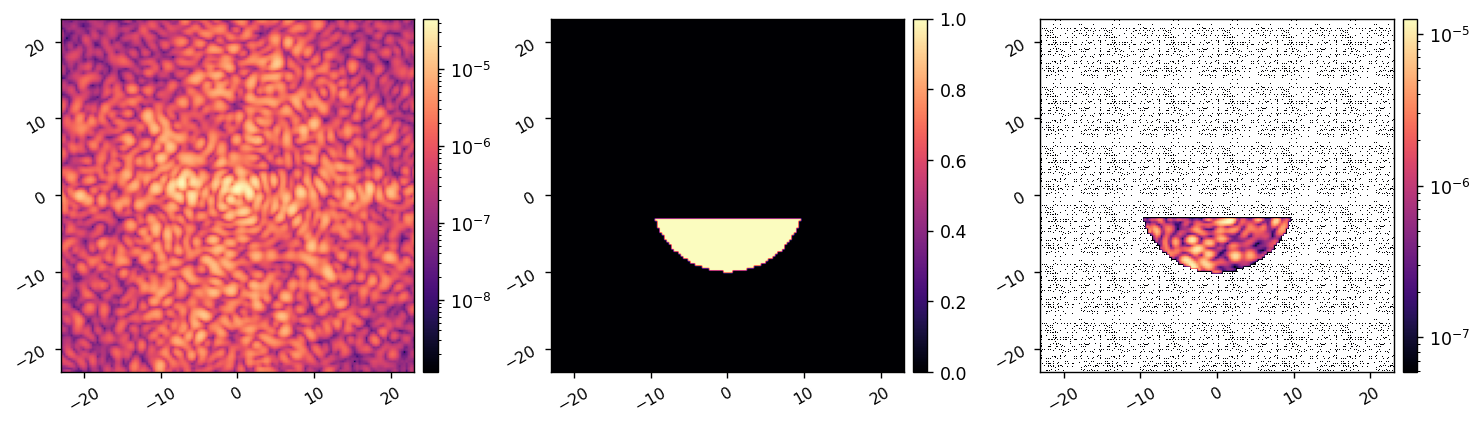

In [83]:
iwa = 3
owa = 10
rotation = 90
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, iwa, owa, edge=iwa, rotation=rotation)

I.zero_dm()
I.NSCICAM = 50
I.subtract_dark = True
I.return_ni = True

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamDc)

In [85]:
I.zero_dm()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'commands':[],
    'del_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

In [89]:
I.set_fib_atten(0, client)

Set the fiber attenuation to 0.0


Running iteration 50
Running PWP ...


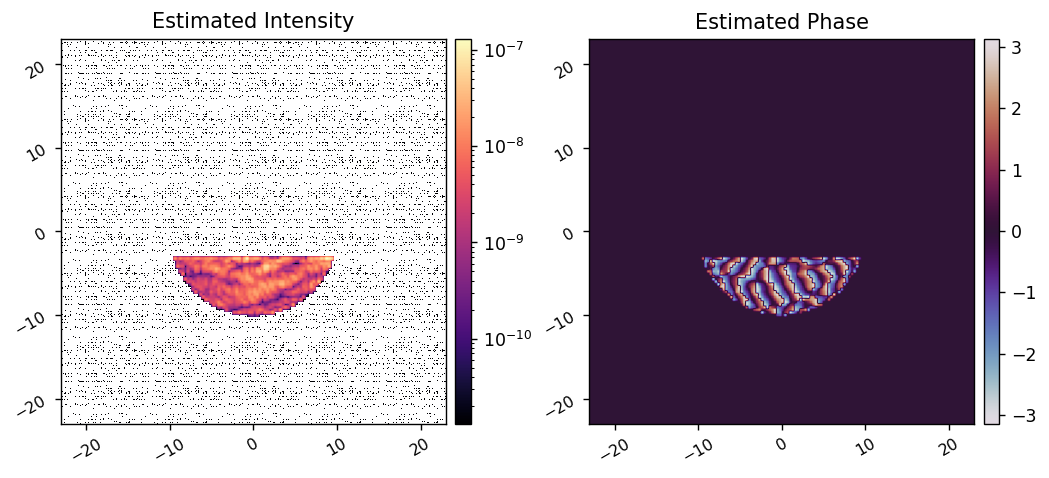

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  6.65088D+07

At iterate    1    f=  9.58329D-01    |proj g|=  3.16011D+07

At iterate    2    f=  9.49896D-01    |proj g|=  1.86580D+07

At iterate    3    f=  9.42565D-01    |proj g|=  9.69874D+06

At iterate    4    f=  9.38604D-01    |proj g|=  9.48045D+06

At iterate    5    f=  9.35142D-01    |proj g|=  7.99193D+06

At iterate    6    f=  9.32502D-01    |proj g|=  6.76950D+06

At iterate    7    f=  9.29633D-01    |proj g|=  6.67775D+06

At iterate    8    f=  9.28208D-01    |proj g|=  1.41235D+07

At iterate    9    f=  9.26197D-01    |proj g|=  6.90026D+06

At iterate   10    f=  9.24510D-01    |proj g|=  7.68352D+06

At iterate   11    f=  9.23383D-01    |proj g|=  9.62642D+06

At iterate   12    f=  9.22580D-01    |proj g|=  8.98146D+06

           * * *

Tit   = 

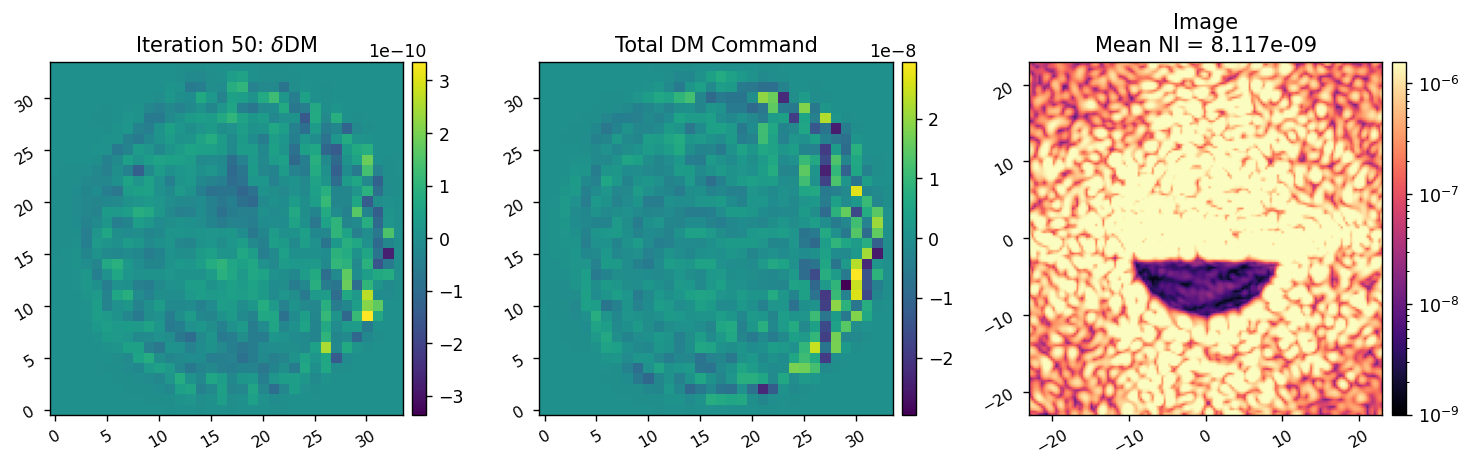

In [123]:
reload(scoobm)
reload(aefc)

I.NSCICAM = 30

bfgs_tol = 1e-2
bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':True,
    'maxiter':25,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

pwp_params = {
    'control_mask':control_mask, 
    'probes':fourier_probes,
    'probe_amp':2.5e-9,
    # 'probe_amp':1.5e-9,
    'probe_amp':1e-9,
    # 'probe_amp':0.75e-9,
    'probe_amp':0.5e-9,
    'probe_amp':0.3e-9,
    'probe_amp':0.2e-9,
    'wavelength':I.wavelength_c,
    'reg_cond':1e-2,
    'reg_cond':1e-3,
    # 'reg_cond':1e-4,
    'gain':2,
    'Ndms':1,
    # 'plot':True,
    'plot_est':True, 
}

data = aefc.run(
    I, 
    M, 
    scoobm.val_and_grad, 
    control_mask, 
    data,
    pwp_params=pwp_params,
    # Nitr=1, reg_cond=1e-1,
    Nitr=1, reg_cond=1e-2,
    # Nitr=2, reg_cond=1e-3,
    # Nitr=2, reg_cond=1e-4,
    # Nitr=2, reg_cond=1e-5,
    # Nitr=2, reg_cond=1e-6,
    # Nitr=2, reg_cond=1e-7,
    # Nitr=2, reg_cond=1e-8,
    # Nitr=2, reg_cond=1e-9,
    # Nitr=2, reg_cond=1e-10,
    bfgs_tol=bfgs_tol,
    bfgs_opts=bfgs_opts,
    gain=1,
    vmin=1e-9, 
)

In [124]:
utils.save_pickle(f'data/{today}_scoob_aefc_run.pkl', data)

Saved data to:  data/20250121_scoob_aefc_run.pkl


In [134]:
I.set_fib_atten(0, client)

Set the fiber attenuation to 0.0


8.184277616041753e-09


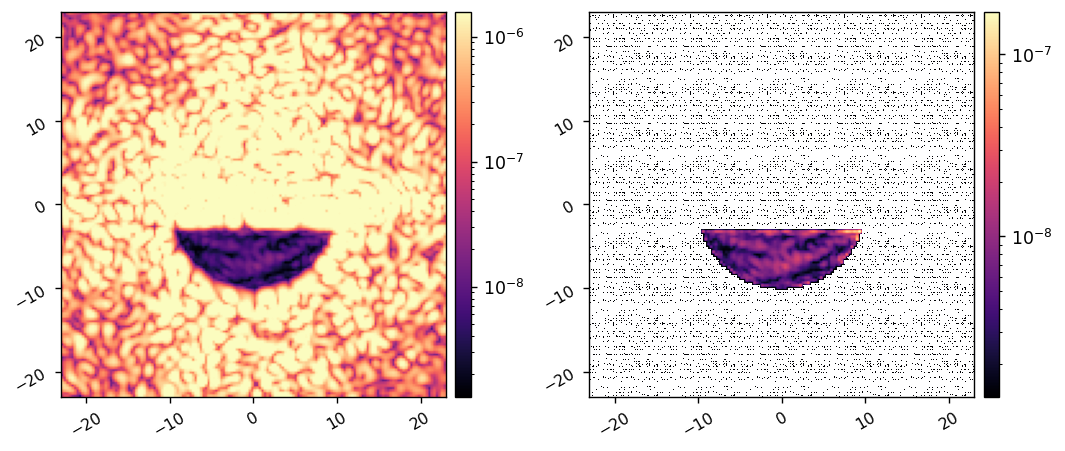

In [133]:
I.NSCICAM = 100
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[control_mask]))
imshow2(coro_im, control_mask * coro_im,
        lognorm=True, pxscl=I.psf_pixelscale_lamDc)

In [135]:
I.zero_dm()
I.set_zwo_exp_time(0.001, client0)
I.set_fib_atten(5, client)

Set the ZWO exposure time to 1.00e-03s
Set the fiber attenuation to 5.0


In [127]:
I.set_zwo_exp_time(0.001, client0)

Set the ZWO exposure time to 1.00e-03s


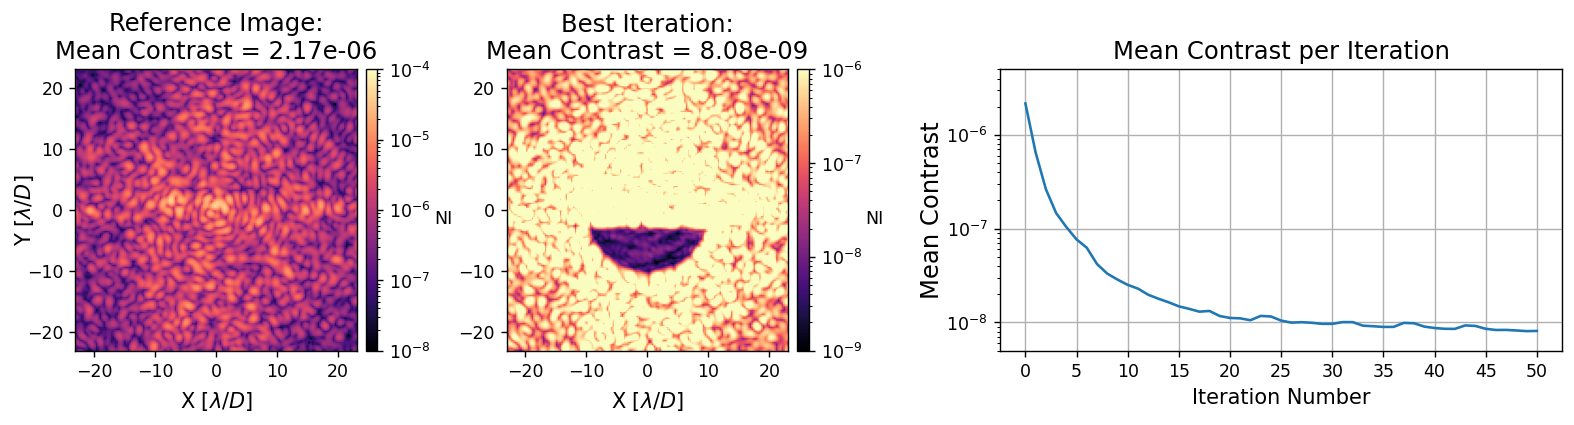

In [136]:
from adefc_vortex import imshows
reload(imshows)

old_data = utils.load_pickle('data/20250121_scoob_aefc_run.pkl')

imshows.plot_data_with_ref(
    old_data, 
    im1vmax=1e-4, im1vmin=1e-8, 
    im2vmax=1e-6, im2vmin=1e-9, 
    vmax=5e-6, vmin=5e-9, 
    xticks=np.arange(0, 50+1, 5),
)


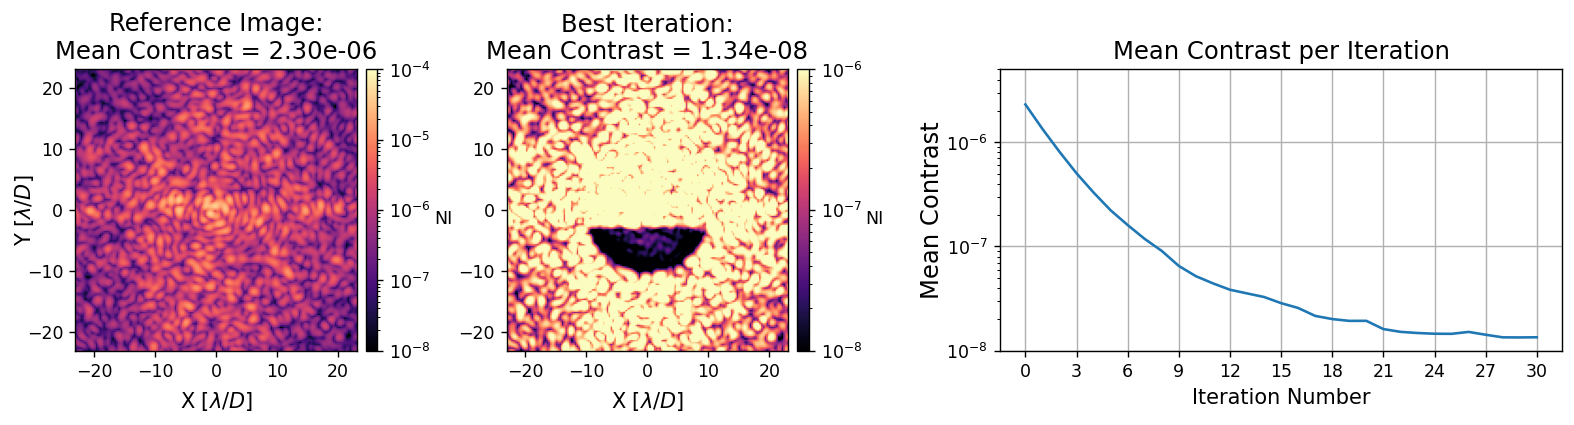

In [162]:
from adefc_vortex import imshows
reload(imshows)

old_data = utils.load_pickle('data/20250117_scoob_aefc_run.pkl')

imshows.plot_data_with_ref(
    old_data, 
    im1vmax=1e-4, im1vmin=1e-8, 
    im2vmax=1e-6, im2vmin=1e-8, 
    vmax=5e-6, vmin=1e-8, 
    xticks=np.arange(0, 30+1, 3),
)

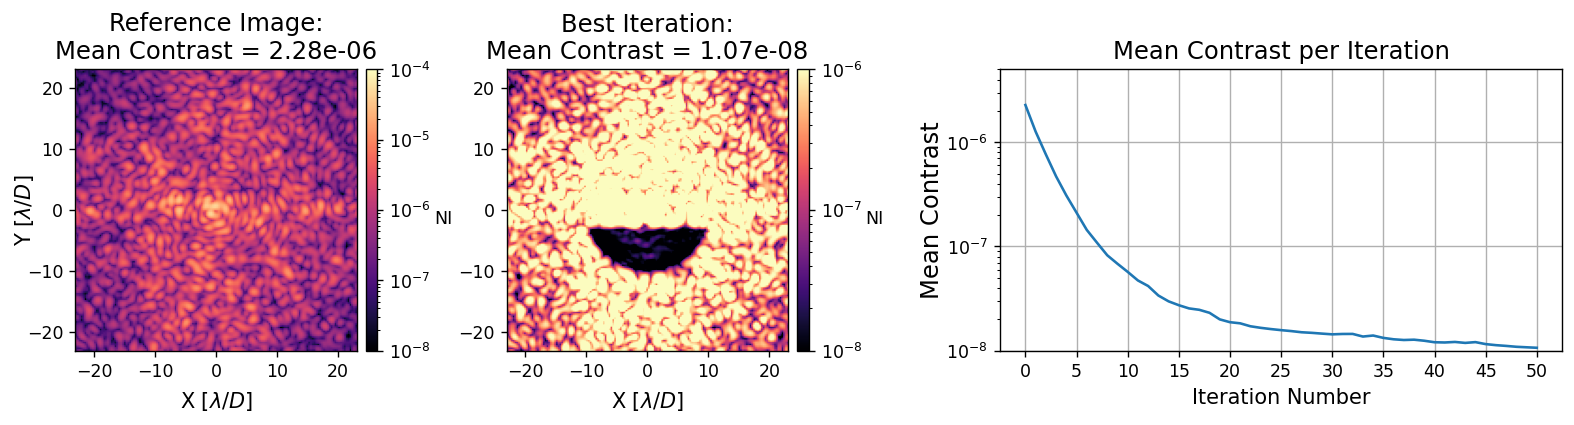

In [179]:
from adefc_vortex import imshows
reload(imshows)

old_data = utils.load_pickle('data/20250117_scoob_aefc_run_2.pkl')

imshows.plot_data_with_ref(
    old_data, 
    im1vmax=1e-4, im1vmin=1e-8, 
    im2vmax=1e-6, im2vmin=1e-8, 
    vmax=5e-6, vmin=1e-8, 
    xticks=np.arange(0, 50+1, 5),
)

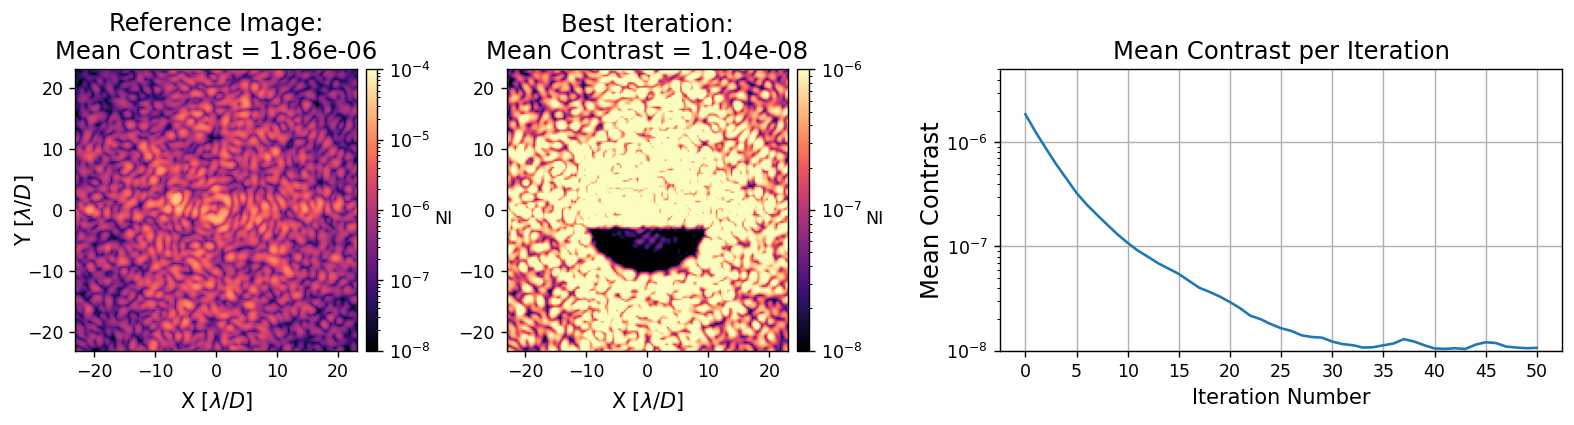

In [180]:
from adefc_vortex import imshows
reload(imshows)

old_data = utils.load_pickle('data/20250115_scoob_aefc_run.pkl')

imshows.plot_data_with_ref(
    old_data, 
    im1vmax=1e-4, im1vmin=1e-8, 
    im2vmax=1e-6, im2vmin=1e-8, 
    vmax=5e-6, vmin=1e-8, 
    xticks=np.arange(0, 50+1, 5),
)

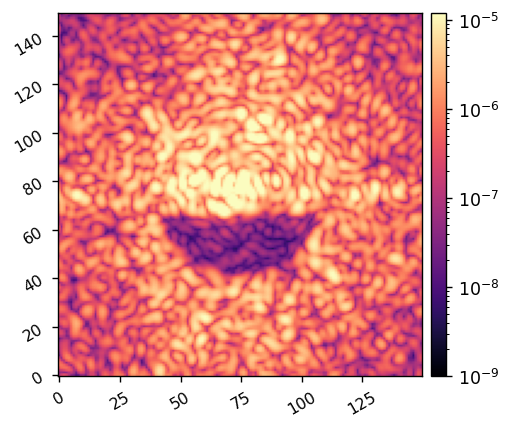

In [ ]:
imshow1(old_data['images'][10], lognorm=1, vmin=1e-9)


In [133]:
old_data['reg_conds']

[0.01,
 0.01,
 1e-05,
 1e-05,
 0.01,
 0.01,
 1e-06,
 1e-06,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 1e-06,
 1e-06,
 0.1,
 0.1,
 0.001,
 0.001,
 0.1,
 0.1,
 1e-06,
 1e-06,
 0.1,
 0.1,
 0.001,
 0.001,
 1e-07,
 1e-07,
 0.1,
 0.1,
 0.1,
 0.1,
 0.001,
 0.001,
 1e-08,
 1e-08,
 0.1,
 0.1,
 0.1,
 0.01,
 0.01,
 0.01,
 1e-07,
 1e-07,
 0.1,
 0.1,
 0.01,
 0.01,
 0.01]